In [317]:
import random
import numpy as np
from numpy import math
import matplotlib.pyplot as plt
import time

In [318]:
def generar_poblacion_suboptima(tamanio_poblacion, longitud_cromosoma):
    return [''.join(random.choice('01') for _ in range(int(longitud_cromosoma))) for _ in range(tamanio_poblacion)]

In [319]:
def sacar_longitud(c,m ):
    longitud = 0
    while c > 1 :
        if (c>=m):
            longitud += bits_ciudad
        else:
            longitud += bits_ciudad-1
        c -= 1
    return longitud
    

In [320]:
def ciudades_cercanas(ciudad):
    global tabla_costes_aux
    fila = tabla_costes_aux[ciudad]
    fila[ciudad] = 100000000
    
    minima_distancia = min(fila) 
    ciudad_cercana = np.argmin(fila)
    tabla_costes_aux[ciudad][ciudad_cercana] = 1000000000
    return int(ciudad_cercana)

In [321]:
def crear_tabla_distancias(ciudades):
    i = 0
    tabla = np.zeros((len(ciudades),len(ciudades)-1))
    for ciudad in ciudades:
        for j in range (0,len(ciudades)-1):
            ciudad_cercana = ciudades_cercanas(ciudad)
            tabla[i][j] = int(ciudad_cercana)
            j += 1
        i += 1
    return tabla

In [322]:
def decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades):
    c = num_ciudades-1
    recorrido = []
    posiciones = sacar_posiciones(num_ciudades,cromosoma,m)
    primera_ciudad = ciudades[0]
    #primera_ciudad =  ciudades[random.randint(0, num_ciudades-1)]
    recorrido.append(primera_ciudad)    
    fila = int(primera_ciudad)
    for i in range (0,len(posiciones)):
        columna = int(posiciones[i])
        siguiente_ciudad = int(tabla_distancias[fila][columna])
        while siguiente_ciudad in recorrido:
            columna += 1
            siguiente_ciudad = int(tabla_distancias[fila][columna])
        fila = int(siguiente_ciudad)           
        recorrido.append(siguiente_ciudad)
    #añadir la que falta
    for ciudad in ciudades:
        if not ciudad in recorrido:
            recorrido.append(ciudad)
    return recorrido

In [323]:
def sacar_posiciones(num_ciudades,cromosoma,m):
    posiciones = []
    bits_ciudad = int(np.log2(m))
    contador_ciudades = num_ciudades
    i = 0
    while contador_ciudades > m :
        bits = ""
        for j in range (i,i+(bits_ciudad)):
            bits += ((cromosoma[j]))  
            i += 1
        posiciones.append(int(bits,2))        
        contador_ciudades -= 1
    while contador_ciudades > 2:
        posiciones.append(int(cromosoma[i],2))
        i += 1
        contador_ciudades -= 1
    return posiciones

In [324]:
def calcular_distancia_total(individuo, df):
    # Aquí implementa el cálculo de la distancia total basado en el vector S
        ciudad_actual = individuo[0]  # Obtén la primera ciudad
        distancia_total = 0
    
        for i in range(1, len(df)):
            siguiente_ciudad = individuo[i]

            distancia_total += df[ciudad_actual][siguiente_ciudad]
            ciudad_actual = siguiente_ciudad

        # Regresa a la ciudad de inicio
        distancia_total += df[ciudad_actual][individuo[0]]

        return distancia_total

In [325]:
def seleccionar_individuo_ruleta(poblacion, aptitudes):
    total_aptitud = sum(aptitudes)
    probabilidad = [aptitud / total_aptitud for aptitud in aptitudes]
    return random.choices(poblacion, probabilidad)[0]

In [326]:
def seleccionar_individuo_torneo(poblacion, aptitudes):
    k=5
    population_size = len(poblacion)
    tournament = random.sample(range(population_size), k)  # Selecciona 'k' individuos al azar para el torneo
    winner = min(tournament, key=lambda i: aptitudes[i])  # Elige al individuo con la menor aptitud en el torneo
    winner = poblacion[winner]
    return winner

In [327]:
def mutar_individuo(individuo, num_generaciones):
    probabilidad_mutacion = 0.4
    if num_generaciones > 1000:
        probabilidad_mutacion = probabilidad_mutacion/2
    if num_generaciones > 2000:
        probabilidad_mutacion = probabilidad_mutacion/4
    if num_generaciones > 4000:
        probabilidad_mutacion = probabilidad_mutacion/8
    if num_generaciones > 8000:
        probabilidad_mutacion = probabilidad_mutacion/10    
    if num_generaciones > 15000:
        probabilidad_mutacion = probabilidad_mutacion/20
                   
    mutado = list(individuo)
    for i in range(len(individuo)):
        if random.random() < probabilidad_mutacion:
            # Cambia el bit si la probabilidad de mutación se cumple
            mutado[i] = '0' if individuo[i] == '1' else '1'
    return ''.join(mutado)

In [328]:
def find_best_individual(population, fitness_values):
    # Encontrar y registrar al mejor individuo en la población.
    best_index = fitness_values.index(min(fitness_values))
    best_individual = population[best_index]

    return best_individual

def replace_worst_with_best(population, fitness_values, best_individual):
    # Encontrar el peor individuo y sustituirlo por el mejor individuo si es superior.
    worst_index = fitness_values.index(min(fitness_values))
    if evaluar_aptitud(best_individual) > fitness_values[worst_index]:
        population[worst_index] = best_individual

def cruzamiento_un_punto(padre1, padre2, longitud_cromosoma):
    medio = int(longitud_cromosoma/2)
    punto_cruzamiento = random.randint(1, longitud_cromosoma-1)  # Se elige un punto de cruzamiento aleatorio (excepto el primer y último bit)
   
    hijo1 = padre1[:punto_cruzamiento] + padre2[punto_cruzamiento:]
    hijo2 = padre2[:punto_cruzamiento] + padre1[punto_cruzamiento:]

    return hijo1, hijo2

In [329]:
import numpy as np

def nsga_ii(poblacion, tabla_distancias,ciudades):
    # Calcular la aptitud para cada individuo en la población
    distances = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades), tabla_costes) for cromosoma in poblacion]
    costs = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades),costes_distancias) for cromosoma in poblacion]

    # Clasificar a los individuos en frentes de Pareto
    pareto_fronts = fast_non_dominated_sort(distances, costs)

    # Calcular la distancia de aglomeración para cada individuo
    crowding_distances = []
    for front in pareto_fronts:
        front_distances = compute_crowding_distance(front, distances, costs)
        crowding_distances.extend(front_distances)

    # Seleccionar individuos para la próxima generación basado en la clasificación de Pareto y la distancia de aglomeración
    next_generation = select_next_generation(poblacion, pareto_fronts, crowding_distances)

    return next_generation

def fast_non_dominated_sort(distances, costs):
    S = [[] for _ in range(len(distances))]
    n = [0 for _ in range(len(distances))]
    ranks = [0 for _ in range(len(distances))]
    fronts = [[]]

    for p in range(len(distances)):
        for q in range(len(distances)):
            if (distances[p] < distances[q] and costs[p] < costs[q]) or (distances[p] <= distances[q] and costs[p] < costs[q]) or (distances[p] < distances[q] and costs[p] <= costs[q]):
                S[p].append(q)
            elif (distances[q] < distances[p] and costs[q] < costs[p]) or (distances[q] <= distances[p] and costs[q] < costs[p]) or (distances[q] < distances[p] and costs[q] <= costs[p]):
                n[p] += 1
        if n[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    del fronts[-1]
    return fronts

def compute_crowding_distance(front, distances, costs):
    # Inicializar distancias a 0
    l = len(front)
    distance = [0 for _ in range(l)]
    
    # Si el frente tiene menos de 3 individuos, devolver infinito para todos
    if l < 3:
        return [float('inf') for _ in range(l)]
    
    for m, objs in enumerate([distances, costs]):
        # Ordenar según el objetivo m y actualizar la distancia
        sorted_front = sorted(front, key=lambda x: objs[x])
        distance[0] = distance[-1] = float('inf')
        norm = max(objs) - min(objs)
        for i in range(1, l - 1):
            distance[i] += (objs[sorted_front[i + 1]] - objs[sorted_front[i - 1]]) / norm
    return distance

def select_next_generation(poblacion, pareto_fronts, crowding_distances, size=None):
    if size is None:
        size = len(poblacion)
    
    next_population = []
    for front in pareto_fronts:
        if len(next_population) + len(front) <= size:
            next_population.extend([poblacion[i] for i in front])
        else:
            sorted_front = sorted(front, key=lambda x: (-crowding_distances[x]))
            next_population.extend([poblacion[i] for i in sorted_front[:size - len(next_population)]])
            break
    return next_population


In [330]:
import numpy as np
def nsga(poblacion, poblacion_coste,num_ciudades,m,tabla_distancias,ciudades):
    

    # Supongamos que tienes dos listas de población: 'population_distances' y 'population_costs', que representan las soluciones.
 
    # Supongamos que tienes dos funciones de cálculo de fitness, 'calculate_fitness_distances' y 'calculate_fitness_costs', que devuelven listas de valores de fitness para las distancias y los costos, respectivamente.


    # Tamaño de la población
    population_size = len(poblacion)
    unprocessed_individuals = poblacion.copy()

    # Ejecución de NSGA-II

        # Evaluar el fitness de la población para ambas dimensiones
    aptitudes_distances = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades), tabla_costes) for cromosoma in poblacion]
    aptitudes_costs = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades),costes_distancias) for cromosoma in poblacion]
    aptitudes = list(zip(aptitudes_distances, aptitudes_costs, poblacion))
    # Crear conjuntos de Pareto para ambas dimensiones
    print(len(aptitudes))

    pareto_fronts = []

    for _ in range(len(unprocessed_individuals)):
        pareto_front = []
        for i in range(len(unprocessed_individuals)):
            dominates_others = [aptitudes[i][0] <= aptitudes[j][0] and aptitudes[i][1] <= aptitudes[j][1] for j in range(len(unprocessed_individuals))]
            if all(dominates_others):
                
                pareto_front.append(aptitudes[i][2]) # Añadir el identificador del individuo a 'pareto_front'
                # Eliminar el individuo dominante de 'aptitudes' y 'unprocessed_individuals'
                aptitudes.pop(i)
                unprocessed_individuals.pop(i)
                break                
        pareto_fronts.append(pareto_front)
        
    # Seleccionar soluciones para la próxima generación
    next_generation = []
    remaining_space = population_size//2

    for front in pareto_fronts:
        print(f"front: {front}")
        if len(next_generation) + len(front) <= remaining_space:
            next_generation.extend(front)
        else:
            # Convertir 'front' a un array de NumPy para el cálculo de la norma y la reordenación
            front_array = np.array(front)
            
            # Calcular la distancia de aglomeración (si 'front' es una lista de soluciones, 
            # es posible que necesites convertir cada solución en una representación numérica primero).
            crowding_distance = np.linalg.norm(front_array)
            
            # Reordenar 'front' basado en 'crowding_distance'
            sorted_indices = crowding_distance.argsort()[::-1]
            front_sorted = front_array[sorted_indices]
            
            # Añadir las soluciones ordenadas a la próxima generación hasta que se llene el espacio restante.
            next_generation.extend([x for x in front_sorted[:remaining_space]]) # No es necesario convertir a lista, ya es una lista de identificadores

            
            # Una vez que hemos llenado el espacio restante, podemos salir del bucle.
            break

    # Actualizar la población actual con las soluciones seleccionadas
    poblacion = next_generation.copy()
    return poblacion






Generación 1: Distancia: 16290.91 Coste:7796.120000000003
Generación 2: Distancia: 16168.500000000002 Coste:7796.120000000003
Generación 3: Distancia: 16168.500000000002 Coste:7796.120000000003
Generación 4: Distancia: 16168.500000000002 Coste:7796.120000000003
Generación 5: Distancia: 16168.500000000002 Coste:7772.43
Generación 6: Distancia: 16168.500000000002 Coste:7772.43
Generación 7: Distancia: 16168.500000000002 Coste:7772.43
Generación 8: Distancia: 16168.500000000002 Coste:7772.43
Generación 9: Distancia: 16114.3 Coste:7772.43
Generación 10: Distancia: 16114.3 Coste:7772.43
Generación 11: Distancia: 16114.3 Coste:7772.43
Generación 12: Distancia: 15911.519999999997 Coste:7745.860000000001
Generación 13: Distancia: 15911.519999999997 Coste:7745.860000000001
Generación 14: Distancia: 15911.519999999997 Coste:7745.860000000001
Generación 15: Distancia: 15911.519999999997 Coste:7745.860000000001
Generación 16: Distancia: 15911.519999999997 Coste:7745.860000000001
Generación 17: Dis

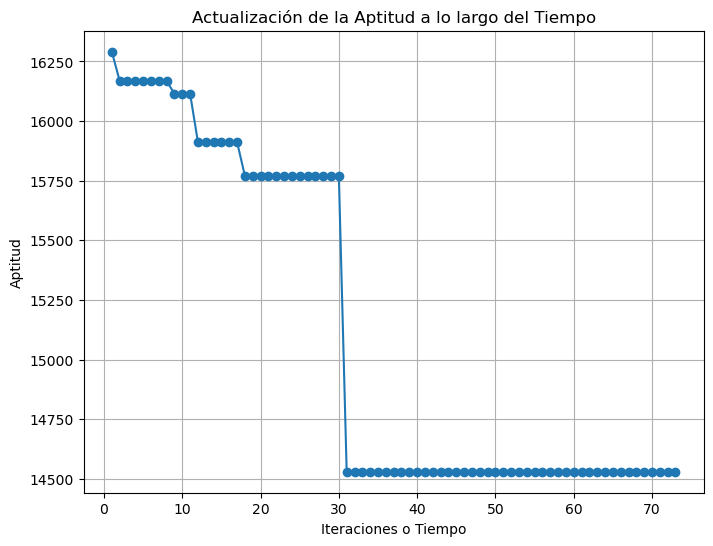

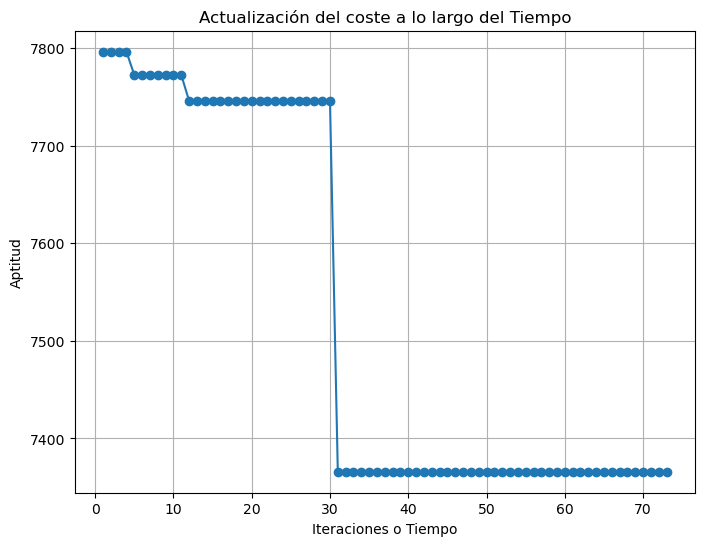

In [332]:
tabla_costes = np.load('tsp.md.npy') 
tabla_costes_aux = tabla_costes.copy()
costes_distancias = np.load('tsp.md.cost.npy') 
costes_distancias_aux = costes_distancias.copy() 

num_ciudades = len(tabla_costes)
tamanio_poblacion = 10
c = num_ciudades-1
ciudades = list(range(0,num_ciudades))
m = 4
bits_ciudad = np.log2(m)
aptitudgraph = []
costegraph = []
longitud_cromosoma = sacar_longitud(c,m)    
tabla_distancias = crear_tabla_distancias(ciudades)
poblacion = generar_poblacion_suboptima(tamanio_poblacion,longitud_cromosoma)
indx = 0
num_generaciones = 0
tiempo_limite = 120
tiempo_inicio = time.time()
while indx < 1:
    # Evaluación de aptitud
    
    aptitudes = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades), tabla_costes) for cromosoma in poblacion]
    mejor_individuo = find_best_individual(poblacion, aptitudes)
    # Selección
    nueva_poblacion = []
    

    for _ in range(tamanio_poblacion // 2):
        padre1 = seleccionar_individuo_torneo(poblacion, aptitudes)
        padre2 = seleccionar_individuo_torneo(poblacion, aptitudes)

        hijo1, hijo2 = cruzamiento_un_punto(padre1, padre2,longitud_cromosoma)
        nueva_poblacion.extend([hijo1, hijo2])
        
    nueva_poblacion = [mutar_individuo(individuo,num_generaciones) for individuo in nueva_poblacion]
    poblacion.extend(nueva_poblacion)
    
    #nueva_poblacion = nsga(poblacion, nueva_poblacion,num_ciudades,m,tabla_distancias,ciudades)
    nueva_poblacion= nsga_ii(poblacion, tabla_distancias,ciudades)
    #print(len(nueva_poblacion))
    #for _ in range(tamano_poblacion // 2):
        #selected_parents = tournament_selection(poblacion, aptitudes)
        #hijo1, hijo2 = cruzamiento_un_punto(selected_parents[0], selected_parents[1])
        #nueva_poblacion.extend([hijo1, hijo2])
    # Mutación


    # Reemplazar la población anterior con la nueva población
    poblacion = nueva_poblacion
    
    
    #replace_worst_with_best(poblacion, aptitudes, mejor_individuo)

    # Mostrar la aptitud del mejor individuo en esta generación
    aptitudes = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades), tabla_costes) for cromosoma in poblacion]
    aptitudes_costs = [calcular_distancia_total(decod_suboptima(num_ciudades,cromosoma,m,tabla_distancias,ciudades),costes_distancias) for cromosoma in poblacion]
    poblacion[aptitudes.index(max(aptitudes))] = mejor_individuo
    mejor_individuo_generacion = poblacion[aptitudes.index(min(aptitudes))]
    mejor_aptitud_generacion = min(aptitudes)
    mejor_coste = min(aptitudes_costs)
    num_generaciones += 1
    if(num_generaciones % 1 == 0): # Every 1 epochs
        print(f"Generación {num_generaciones}: Distancia: {mejor_aptitud_generacion} Coste:{mejor_coste}")
    
    aptitudgraph.append(mejor_aptitud_generacion)
    costegraph.append(mejor_coste)
    tiempo_transcurrido = time.time() - tiempo_inicio
    if tiempo_transcurrido >= tiempo_limite: indx += 1
print(f"Distancia: {mejor_aptitud_generacion} Coste:{mejor_coste}")
iteraciones = list(range(1, len(aptitudgraph) + 1))

# Crea la gráfica de línea
plt.figure(figsize=(8, 6))
plt.plot(iteraciones, aptitudgraph, marker='o', linestyle='-')
plt.title('Actualización de la Aptitud a lo largo del Tiempo')
plt.xlabel('Iteraciones o Tiempo')
plt.ylabel('Aptitud')
plt.grid(True)

# Muestra la gráfica
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(iteraciones, costegraph, marker='o', linestyle='-')
plt.title('Actualización del coste a lo largo del Tiempo')
plt.xlabel('Iteraciones o Tiempo')
plt.ylabel('Aptitud')
plt.grid(True)

# Muestra la gráfica
plt.show()